**NOTE**: data selection process occurs in the `fig1-pose-manifold-classifier` processing notebook; just loading the data here

In [1]:
import joblib
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from sklearn.decomposition import PCA
from toolz import valmap, compose
# from sklearn.cluster import k_means
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import (
    cross_val_score,
    StratifiedKFold,
    RepeatedStratifiedKFold,
    cross_val_predict,
)
from aging.plotting import format_plots, PlotConfig, save_factory, figure, legend
from sklearn.metrics import confusion_matrix

In [2]:
c = PlotConfig()
format_plots()
saver = save_factory(c.save_path / "network-optim", tight_layout=False)

In [3]:
# tmp = joblib.load('/n/scratch3/users/w/wg41/aging-aligned-frames.p')
tmp = joblib.load('/n/scratch3/users/w/wg41/aging-aligned-frames-pose-resampled.p')
all_frames = tmp['frames']
all_recon_frames = tmp['recon']

In [4]:
frames_per_sample = 6_000

In [5]:
def flatten(x):
    return x.reshape(len(x), -1)


def multi_stage_pca(data, subset_frames=200, total_frames=7000, seed=0):
    np.random.seed(seed)

    train = []
    for k, v in data.items():
        train.append(v[np.random.permutation(np.arange(len(v)))[:subset_frames]])
    train = np.concatenate(train, axis=0)

    pca = PCA(n_components=10).fit(train.reshape(len(train), -1))

    pcs = valmap(
        compose(
            pca.transform,
            flatten,
            lambda v: v[np.random.permutation(np.arange(len(v)))[:total_frames]],
        ),
        data,
    )
    return pcs

## Decode age from frame

In [15]:
pipeline = make_pipeline(
    StandardScaler(),
    LogisticRegression(max_iter=200, class_weight='balanced'),
)

### Transformed

In [13]:
pcs = multi_stage_pca(
    all_recon_frames, total_frames=1000, subset_frames=1000
)

In [17]:
x = np.concatenate(list(pcs.values()), axis=0)
ages = np.concatenate([[k[-1]] * len(v) for k, v in pcs.items()])

In [31]:
trans_out = cross_val_score(
    pipeline,
    x,
    ages,
    cv=RepeatedStratifiedKFold(n_splits=4, n_repeats=3, random_state=0),
    n_jobs=-1,
)
trans_out

array([0.2704    , 0.27578182, 0.26632727, 0.26814545, 0.26661818,
       0.26501818, 0.26770909, 0.27512727, 0.26501818, 0.27192727,
       0.26778182, 0.27003636])

In [32]:
np.mean(trans_out)

0.2691575757575757

In [33]:
lr_preds = cross_val_predict(
    pipeline,
    x,
    ages,
    cv=StratifiedKFold(4),
    n_jobs=-1,
)

In [34]:
col = np.unique(ages)
cm = confusion_matrix(ages, lr_preds, labels=col)

cm_df = pd.DataFrame(cm / cm.sum(1, keepdims=True), columns=col, index=col)

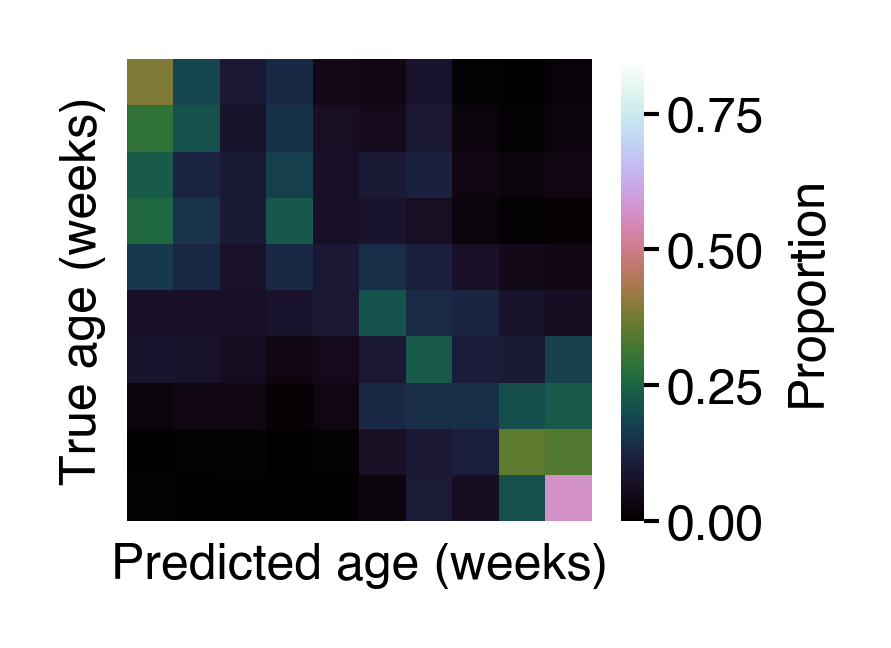

In [35]:
fig = figure(1.25, 1)
ax = sns.heatmap(
    cm_df,
    annot=False,
    cmap="cubehelix",
    cbar_kws=dict(label="Proportion"),
    vmax=0.85,
    vmin=0,
    xticklabels=False,
    yticklabels=False,
)
ax.set(xlabel='Predicted age (weeks)', ylabel='True age (weeks)')
saver(fig, 'transformed-pose-age-classification-confusion-mtx');

In [36]:
np.random.seed(0)
shuff_trans_out = []
for i in tqdm(range(25)):
    shuff_trans_out.extend(cross_val_score(
        pipeline,
        x,
        np.random.permutation(ages),
        cv=StratifiedKFold(4),
        n_jobs=-1,
    ))
shuff_trans_out = np.array(shuff_trans_out)

  0%|          | 0/25 [00:00<?, ?it/s]

### Original

In [37]:
pcs = multi_stage_pca(
    all_frames, total_frames=1000, subset_frames=1000
)

In [38]:
x = np.concatenate(list(pcs.values()), axis=0)
ages = np.concatenate([[k[-1]] * len(v) for k, v in pcs.items()])

In [39]:
raw_out = cross_val_score(
    pipeline,
    x,
    ages,
    cv=RepeatedStratifiedKFold(n_splits=4, n_repeats=3, random_state=0),
    n_jobs=-1,
)
raw_out

array([0.48785455, 0.48814545, 0.47323636, 0.48276364, 0.48261818,
       0.48043636, 0.47810909, 0.48647273, 0.48407273, 0.4816    ,
       0.47912727, 0.48625455])

In [40]:
lr_preds = cross_val_predict(
    pipeline,
    x,
    ages,
    cv=StratifiedKFold(4),
    n_jobs=-1
)

In [41]:
col = np.unique(ages)
cm = confusion_matrix(ages, lr_preds, labels=col)

cm_df = pd.DataFrame(cm / cm.sum(1, keepdims=True), columns=col, index=col)

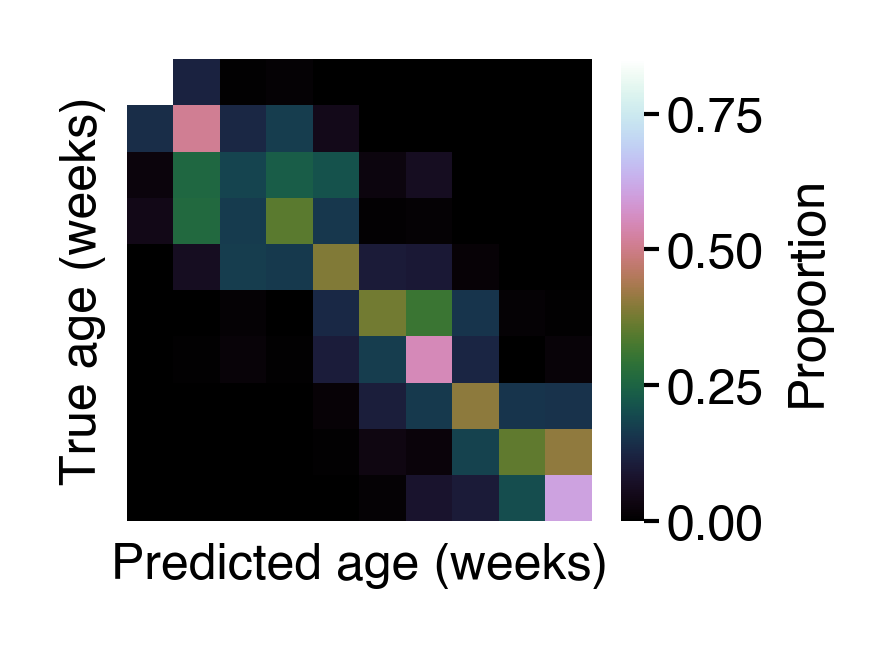

In [42]:
fig = figure(1.25, 1)
ax = sns.heatmap(
    cm_df,
    annot=False,
    cmap="cubehelix",
    cbar_kws=dict(label="Proportion"),
    vmax=0.85,
    vmin=0,
    xticklabels=False,
    yticklabels=False,
)
ax.set(xlabel="Predicted age (weeks)", ylabel="True age (weeks)")
saver(fig, "raw-pose-age-classification-confusion-mtx");

In [43]:
np.random.seed(0)
shuff_raw_out = []
for i in tqdm(range(25)):
    shuff_raw_out.extend(cross_val_score(
        pipeline,
        x,
        np.random.permutation(ages),
        cv=StratifiedKFold(4),
        n_jobs=-1,
    ))
    # print(out)
shuff_raw_out = np.array(shuff_raw_out)

  0%|          | 0/25 [00:00<?, ?it/s]

### Accuracy comparison

In [44]:
outcomes = [
    pd.DataFrame(dict(acc=raw_out, treatment="Observed", type="Original")),
    pd.DataFrame(dict(acc=trans_out, treatment="Observed", type="Transformed")),
    pd.DataFrame(dict(acc=shuff_raw_out, treatment="Shuffle", type="Original")),
    pd.DataFrame(dict(acc=shuff_trans_out, treatment="Shuffle", type="Transformed")),
]
outcomes = pd.concat(outcomes, ignore_index=True)

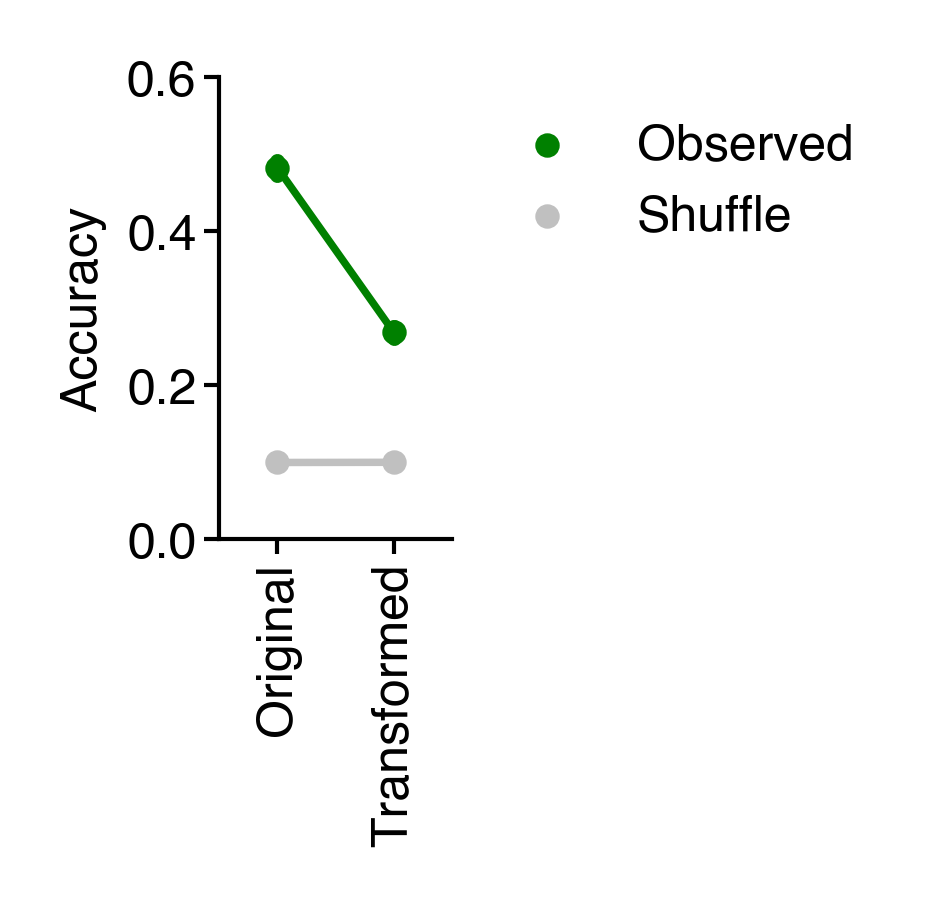

In [45]:
fig = figure(0.5, 1)
ax = sns.pointplot(
    data=outcomes,
    x="type",
    y="acc",
    palette=["green", "silver"],
    hue="treatment",
    hue_order=["Observed", "Shuffle"],
    join=True,
    errorbar=("sd", 2),
    scale=0.5,
)
ax.set(ylim=(0, 0.6), ylabel="Accuracy", xlabel="")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
legend(ax)
sns.despine()
saver(fig, "age-decoder-from-pose-pointplot");

## Decode age from frame PC dynamics